In [1]:
import polars as pl
import pandas as pd

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [2]:
df = pl.read_parquet('../../Data/originatingMail_oWeather.parquet.gzip')

In [3]:
df = df.filter((pl.col('ORIGIN_FACILITY') == 'MUSIC CITY ANNEX - 1532174') &
               (pl.col('EXPECTED_DESTINATION_FACILITY') == 'MUSIC CITY ANNEX - 1532174') &
               (pl.col('ACTUAL_DLVRY_DATE') <= pl.datetime(2024, 1, 27))) 

In [4]:
df.columns

['UNIQUE_IDENTIFIER',
 'START_THE_CLOCK_DATE',
 'ORIGIN_FACILITY',
 'OZIP3',
 'ACTUAL_DLVRY_DATE',
 'EXPECTED_DELIVERY_DATE',
 'EXPECTED_DESTINATION_FACILITY',
 'DZIP3',
 'MAIL_CLASS',
 'MAIL_SHAPE',
 'o_PRCP',
 'o_SNOW',
 'o_TMAX',
 'o_TMIN']

In [5]:
df.group_by('MAIL_CLASS').count()

/var/folders/r6/6lnhxb15071_vwfk77wkdc9m0000gn/T/ipykernel_66532/2502347980.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  df.group_by('MAIL_CLASS').count()


MAIL_CLASS,count
str,u32
"""Periodicals""",392878
"""USPS Marketing Mail""",1342179
"""Single Piece First Class""",74918


In [6]:
weather = pl.read_parquet('../../Data/weatherMailData.parquet.gzip')

In [7]:
weather.head()

date,zip3,PRCP,SNOW,TMAX,TMIN
str,i32,f64,f64,f64,f64
"""2024-01-13T00:00:00""",370,1.46,0.0,57.0,24.0
"""2024-01-14T00:00:00""",307,0.02,0.0,47.0,22.0
"""2024-01-12T00:00:00""",385,0.87,0.0,60.0,23.0
"""2024-01-20T00:00:00""",422,0.02,0.2,30.0,1.0
"""2024-01-25T00:00:00""",307,1.72,0.0,69.0,44.0


In [8]:
weather = weather.select(pl.col('date').str.to_date('%Y-%m-%dT%H:%M:%S'),
                         pl.col('zip3').cast(pl.Int64),
                         pl.col('PRCP').alias('d_PRCP'),
                         pl.col('SNOW').alias('d_SNOW'),
                         pl.col('TMAX').alias('d_TMAX'),
                         pl.col('TMIN').alias('d_TMIN'))

In [9]:
df = df.join(weather, left_on=['DZIP3', 'ACTUAL_DLVRY_DATE'], right_on=['zip3', 'date'])

In [10]:
df = df.drop_nulls()

In [11]:
df.shape

(1809975, 18)

In [12]:
df = df.with_columns(
    pl.when(pl.col('ACTUAL_DLVRY_DATE') > pl.col('EXPECTED_DELIVERY_DATE'))
    .then(1)
    .otherwise(0)
    .alias('isLate')
    )

In [13]:
df.group_by('isLate').len()

isLate,len
i32,u32
0,1696924
1,113051


In [14]:
df.group_by('MAIL_SHAPE').len()

MAIL_SHAPE,len
str,u32
"""Flat""",1809975


In [15]:
df = df.drop(['MAIL_CLASS', 'MAIL_SHAPE'])

In [16]:
df_isLate = df.filter(pl.col('isLate') == 1)

In [17]:
df_onTime = df.filter(pl.col('isLate') == 0)

In [18]:
day_isLate_resampled = resample(df_isLate, random_state=96, n_samples=25000, replace=True)

In [19]:
df_onTime_resampled = resample(df_onTime, random_state=96, n_samples=25000, replace=True)

In [20]:
df_resampled = pl.concat([day_isLate_resampled, df_onTime_resampled])

In [21]:
labelzip = LabelEncoder()

In [22]:
df_model = df_resampled.select(pl.col('DZIP3'),
                               pl.col('o_PRCP'),
                               pl.col('o_SNOW'),
                               pl.col('o_TMAX'),
                               pl.col('o_TMIN'),
                               pl.col('d_PRCP'),
                               pl.col('d_SNOW'),
                               pl.col('d_TMAX'),
                               pl.col('d_TMIN'),
                               pl.col('isLate'))

In [23]:
df_model.shape

(50000, 10)

In [24]:
df_model = df_model.to_pandas()

In [25]:
df_model.head()

,DZIP3,o_PRCP,o_SNOW,o_TMAX,o_TMIN,d_PRCP,d_SNOW,d_TMAX,d_TMIN,isLate
0,384,0.17,0.0,34.0,5.0,2.52,0.0,62.0,48.0,1
1,370,1.27,0.0,57.0,27.0,0.15,0.0,52.0,-13.0,1
2,384,0.17,0.0,34.0,5.0,1.09,0.0,66.0,40.0,1
3,385,1.27,0.0,57.0,27.0,2.11,0.0,67.0,34.0,1
4,371,0.45,0.0,54.0,23.0,1.08,0.0,59.0,24.0,1


In [26]:
df_model['DZIP3'] = labelzip.fit_transform(df_model['DZIP3'])

In [27]:
# Mapping from encoded values to original values
encoded_to_original_zip = {i: label for i, label in enumerate(labelzip.classes_)}

In [28]:
# Separate features and target variable
X = df_model.drop('isLate', axis=1)
y = df_model['isLate']

In [29]:
# Split the data for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

In [30]:
# XGBoost classifier
model = XGBClassifier(eval_metric='logloss')

In [31]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [52]:
# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

In [53]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estima

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [54]:
# Best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_}')

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best cross-validation accuracy: 0.9368500000000001


In [35]:
# Fit the model on the entire training set with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [36]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [37]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9324


In [38]:
# AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc}')

AUC: 0.9861511999078709


In [133]:
# Classification report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      5017
           1       0.92      0.95      0.93      4983

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [134]:
# Feature importance
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

In [135]:
print(importance_df)

  Feature  Importance
6  d_SNOW    0.205985
3  o_TMAX    0.185548
8  d_TMIN    0.155902
7  d_TMAX    0.128020
1  o_PRCP    0.117358
5  d_PRCP    0.105329
4  o_TMIN    0.047817
2  o_SNOW    0.035249
0   DZIP3    0.018792


In [48]:
y_train.value_counts()

isLate
1    20017
0    19983
Name: count, dtype: int64

In [49]:
y_test.value_counts()

isLate
0    5017
1    4983
Name: count, dtype: int64

In [82]:
trainLate = y_train[y_train == 1].index.to_list()

array([[<Axes: title={'center': 'd_SNOW'}>]], dtype=object)

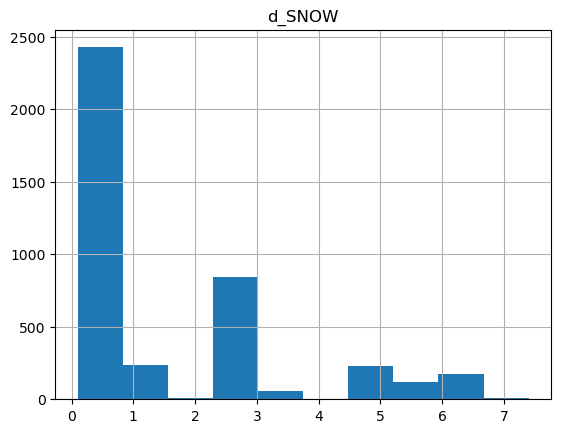

In [87]:
X_train[(X_train.index.isin(trainLate)) & (X_train['d_SNOW'] > 0)].hist('d_SNOW')

In [84]:
trainOnTime = y_train[y_train == 0].index.to_list()

array([[<Axes: title={'center': 'd_SNOW'}>]], dtype=object)

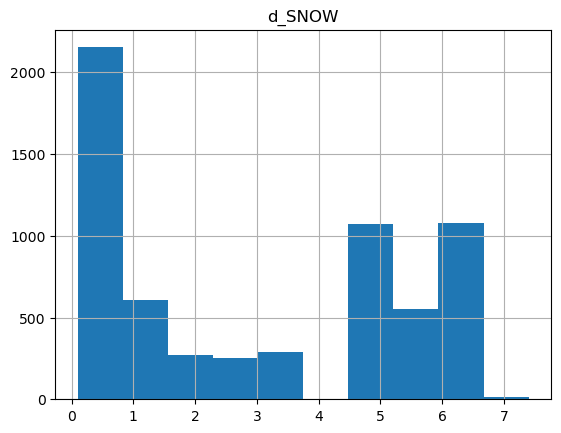

In [86]:
X_train[(X_train.index.isin(trainOnTime)) & (X_train['d_SNOW'] > 0)].hist('d_SNOW')